In [4219]:
from datetime import date

# tratamiento de los datos
# ============================================
import pandas as pd
import numpy as np
import sidetable
# librer√≠as para la visualizaci√≥n de los datos
# ============================================
import matplotlib.pyplot as plt
import seaborn as sns

# Establecer tama√±o fijo de gr√°ficas
# ==================================
plt.rcParams["figure.figsize"] = (10,8)

# Configuraci√≥n warnings
# ======================
import warnings
warnings.filterwarnings('ignore')

from scipy import stats
from scipy.stats import skew
from scipy.stats import kurtosistest
from scipy.stats import levene
import researchpy as rp
from scipy import math
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

# Barra de progreso de un proceso
# ------------------------------------------------------------------------------
from tqdm import tqdm
# Configuraci√≥n warnings
# ------------------------------------------------------------------------------
import warnings
warnings.filterwarnings('once')

# Configuraci√≥n warnings
import warnings
warnings.filterwarnings('ignore')

pd.options.display.max_columns=None


## üå∫üåºüå∑üå∏ Estaciones üå∏üå∑üåºüå∫

In [4220]:
df_original = pd.read_csv("bikes_limpio.csv", index_col=0)
df_original.head(2)

index        date  season  year  month  holiday  weeakday  weathersit  \
0      1  2018-01-01  winter     0      1        1         1           2   
1      2  2018-01-02  winter     0      1        0         2           2   

   sensation  humidity  windspeed  casual  registered  count  
0      18.18     80.58      10.75     331         654    985  
1      17.69     69.61      16.65     131         670    801

In [4221]:
#df=df_original[df_original["season"]=="spring"]
df=df_original.copy()
df.reset_index(drop=True, inplace=True)
df.head(2)

index        date  season  year  month  holiday  weeakday  weathersit  \
0      1  2018-01-01  winter     0      1        1         1           2   
1      2  2018-01-02  winter     0      1        0         2           2   

   sensation  humidity  windspeed  casual  registered  count  
0      18.18     80.58      10.75     331         654    985  
1      17.69     69.61      16.65     131         670    801

#### Eliminamos las columnas que no necesitamos

In [4222]:
df.drop(["date","index"], axis=1, inplace=True)
df.head(2)

season  year  month  holiday  weeakday  weathersit  sensation  humidity  \
0  winter     0      1        1         1           2      18.18     80.58   
1  winter     0      1        0         2           2      17.69     69.61   

   windspeed  casual  registered  count  
0      10.75     331         654    985  
1      16.65     131         670    801

### Variables predictoras

#### Variables numericas

# Gr√°fico de distribuci√≥n para cada variable num√©rica
# ==============================================================================
fig, axes = plt.subplots(nrows = 5, ncols = 2, figsize = (20,10))
axes = axes.flat
columnas_numeric = df.select_dtypes(include = [np.number, "category"]).columns
columnas_numeric = columnas_numeric.drop(["count"])

for i, colum in enumerate(columnas_numeric): 
    sns.histplot(
        data = df,
        x = colum,
        kde = True, 
        color = "pink", 
        line_kws = {"linewidth": 2}, # para indicar el ancho de las l√≠neas de las barras
        alpha = 0.5, # para especificar la transparencia del color
        ax = axes[i])
    
    axes[i].set_title(colum, fontsize = 15, fontweight = "bold")
    axes[i].tick_params(labelsize = 20)
    axes[i].set_xlabel("")

fig.tight_layout()
fig.delaxes(axes[-1])


fig, axes = plt.subplots(nrows = 5, ncols = 2, figsize = (20,10))
axes = axes.flat
columnas_numeric = df.select_dtypes(include = [np.number, "category"]).columns
columnas_numeric = columnas_numeric.drop(["count"])

for i, colum in enumerate(columnas_numeric): 
    sns.boxplot(
        data = df,
        y = "count",
        x=colum,
        color = "pink", 
        ax = axes[i])
    
    axes[i].set_title(colum, fontsize = 15, fontweight = "bold")
    axes[i].tick_params(labelsize = 20)
    axes[i].set_xlabel("")

fig.tight_layout()
fig.delaxes(axes[-1])

plt.figure(figsize=(20,10))
sns.boxplot( 
        data = df,
        y = "count",
        x="weathersit",
        color = "pink")

plt.figure(figsize=(20,10))
sns.boxplot( 
        data = df,
        y = "count",
        x="weeakday",
        color = "pink")

In [4223]:
numericas=df.select_dtypes(include = np.number).drop(["count"], axis=1)
numericas.head()

year  month  holiday  weeakday  weathersit  sensation  humidity  windspeed  \
0     0      1        1         1           2      18.18     80.58      10.75   
1     0      1        0         2           2      17.69     69.61      16.65   
2     0      1        0         3           1       9.47     43.73      16.64   
3     0      1        0         4           1      10.61     59.04      10.74   
4     0      1        0         5           1      11.46     43.70      12.52   

   casual  registered  
0     331         654  
1     131         670  
2     120        1229  
3     108        1454  
4      82        1518

#### Correlaci√≥n entre variables num√©ricas

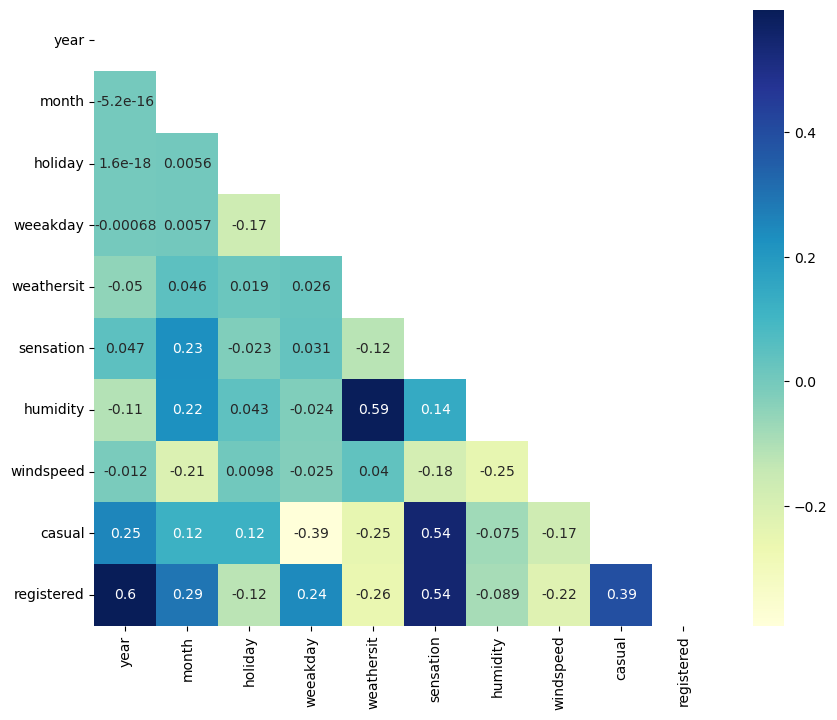

In [4224]:
# creamos un dataframe todo de unos de la misma forma que nuestra matriz de correlaci√≥n

mask = np.triu(np.ones_like(numericas.corr(), dtype = np.bool))

sns.heatmap(numericas.corr(), 
           cmap = "YlGnBu", 
            mask = mask,
            #v_min=-1,
            #v_max=1,
           annot = True);


Hay una relaci√≥n fuerte entre sensaci√≥n y count pero no llega al 70% por lo que detenmos una correlacion moderada

# Estandarizaci√≥n

In [4225]:
from sklearn.preprocessing import RobustScaler

In [4226]:
# construir el modelo de escalador
robust = RobustScaler()

In [4227]:
# iniciamos el m√©todo para escalar
#scaler = StandardScaler()
# Eliminamos las columnas n√∫mericas que no queremos estandarizar
numericas.drop(["weeakday", "weathersit","month","holiday","year"], axis = 1, inplace = True)
numericas.head(2)

sensation  humidity  windspeed  casual  registered
0      18.18     80.58      10.75     331         654
1      17.69     69.61      16.65     131         670

In [4228]:
# ajustamos el modelo utilizando nuestro set de datos
robust.fit(numericas)

# transformamos los datos
X_robust = robust.transform(numericas)
# por √∫ltimo convertiremos el array que nos devuelve en un dataframe. 

numericas_robust = pd.DataFrame(X_robust, columns = numericas.columns)
numericas_robust.head(2)

sensation  humidity  windspeed  casual  registered
0      -0.46      0.86      -0.21   -0.49       -1.32
1      -0.49      0.33       0.69   -0.75       -1.31

In [4229]:
df[numericas_robust.columns] = numericas_robust
df.head()

season  year  month  holiday  weeakday  weathersit  sensation  humidity  \
0  winter     0      1        1         1           2      -0.46      0.86   
1  winter     0      1        0         2           2      -0.49      0.33   
2  winter     0      1        0         3           1      -1.10     -0.90   
3  winter     0      1        0         4           1      -1.02     -0.17   
4  winter     0      1        0         5           1      -0.95     -0.90   

   windspeed  casual  registered  count  
0      -0.21   -0.49       -1.32    985  
1       0.69   -0.75       -1.31    801  
2       0.69   -0.77       -1.07   1349  
3      -0.21   -0.78       -0.97   1562  
4       0.06   -0.81       -0.94   1600

In [4230]:
# ajustamos nuestros datos.  
#scaler.fit(numericas)

# transformamos los datos
#X_escaladas = scaler.transform(numericas)

# por √∫ltimo convertiremos el array que nos devuelve en un dataframe. 

#numericas_estandar = pd.DataFrame(X_escaladas, columns = numericas.columns)
#numericas_estandar.head(2)

In [4231]:
#df[numericas_estandar.columns] = numericas_estandar
df.head()

season  year  month  holiday  weeakday  weathersit  sensation  humidity  \
0  winter     0      1        1         1           2      -0.46      0.86   
1  winter     0      1        0         2           2      -0.49      0.33   
2  winter     0      1        0         3           1      -1.10     -0.90   
3  winter     0      1        0         4           1      -1.02     -0.17   
4  winter     0      1        0         5           1      -0.95     -0.90   

   windspeed  casual  registered  count  
0      -0.21   -0.49       -1.32    985  
1       0.69   -0.75       -1.31    801  
2       0.69   -0.77       -1.07   1349  
3      -0.21   -0.78       -0.97   1562  
4       0.06   -0.81       -0.94   1600

# Arbooleees

## Encoding

In [4232]:
df.reset_index(drop=True, inplace=True)
df.head(2)

season  year  month  holiday  weeakday  weathersit  sensation  humidity  \
0  winter     0      1        1         1           2      -0.46      0.86   
1  winter     0      1        0         2           2      -0.49      0.33   

   windspeed  casual  registered  count  
0      -0.21   -0.49       -1.32    985  
1       0.69   -0.75       -1.31    801

In [4233]:
df.reset_index(drop=True, inplace=True)
## le daremos los n√∫meros m√°s altos a aquellas categor√≠as que sean m√°s importantes, en este caso, al clima bueno
mapa = {3:1,2:2,1:3} 
df["weathersit_map"] = df["weathersit"].map(mapa)

# Columna holiday
#mapa_holi={1:1,0:2}
#df["holiday_map"] = df["holiday"].map(mapa_holi)

# Columna mes
mapa_mes={1:1,2:1,3:2,12:2,4:3,11:3,5:4,6:4,7:4,8:4,9:4,10:4}
df["month_map"] = df["month"].map(mapa_mes)

# Columna a√±o
#mapa_a√±o={0:1,1:2}
#df["year_map"] = df["year"].map(mapa_a√±o)

mapa_season={"winter":1,"autumn":2,"spring":3,"summer":3}
df["season_map"] = df["season"].map(mapa_season)

#columna day
mapa_dia={1:1, 2:2, 3:1, 4:1, 5:2, 6:1, 7:2}
df["weeakday_map"] = df["weeakday"].map(mapa_dia)

In [4234]:
# chequeamos que se hayan hecho los cambios
df.sample(4)

season  year  month  holiday  weeakday  weathersit  sensation  humidity  \
2    winter     0      1        0         3           1      -1.10     -0.90   
498  spring     1      5        0         3           2       0.23      0.78   
229  summer     0      8        0         6           1       0.65      0.13   
232  summer     0      8        0         2           1       0.69      0.68   

     windspeed  casual  registered  count  weathersit_map  month_map  \
2         0.69   -0.77       -1.07   1349               3          1   
498       0.32   -0.48       -0.51   2843               2          4   
229       0.53   -0.10       -0.22   3805               3          4   
232       0.69    0.68       -0.46   3873               3          4   

     season_map  weeakday_map  
2             1             1  
498           3             1  
229           3             1  
232           3             2

In [4235]:
#year = pd.get_dummies(df["year"], prefix_sep = "_", prefix = "year", dtype = int)
#month = pd.get_dummies(df["month"], prefix_sep = "_", prefix = "month", dtype = int)
#holiday = pd.get_dummies(df["holiday"], prefix_sep = "_", prefix = "holiday", dtype = int)
#weeakday = pd.get_dummies(df["weeakday"], prefix_sep = "_", prefix = "weeakday", dtype = int)
#weathersit = pd.get_dummies(df["weathersit"], prefix_sep = "_", prefix = "weathersit", dtype = int)
#season = pd.get_dummies(df["season"], prefix_sep = "_", prefix = "season", dtype = int)

In [4236]:
#df = pd.concat([df,season], axis = 1)
#df.head(2)

In [4237]:
df.drop(["season","weeakday","month","registered","holiday","weathersit","weeakday_map","humidity","month_map","casual"], axis=1, inplace=True)
df.head(2)

year  sensation  windspeed  count  weathersit_map  season_map
0     0      -0.46      -0.21    985               2           1
1     0      -0.49       0.69    801               2           1

## √Årbol

In [4238]:
df.head(2)

year  sensation  windspeed  count  weathersit_map  season_map
0     0      -0.46      -0.21    985               2           1
1     0      -0.49       0.69    801               2           1

In [4239]:
# al igual que en la regresi√≥n lineal tenemos que separar nuestro dataframe en X e y
X = df.drop(["count"], axis = 1)
y = df["count"]
# y dividir nuestros datos en train y test para poder evaluar la bondad de nuestro modelo
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# creamos el objeto del modelo, al igual que hac√≠amos en la regresi√≥n lineal
arbol = DecisionTreeRegressor(random_state =0)

# ajustamos el modelo, igual que en la regresi√≥n lienal. 
arbol.fit(x_train, y_train)

DecisionTreeRegressor(random_state=0)

In [4240]:
# max features. Como vemos, debemos poner en nuestro modelo una profudidad m√°xima de 3.
max_features = np.sqrt(len(x_train.columns))
max_features

2.23606797749979

In [4241]:
# max depth
print(arbol.tree_.max_depth)

18


In [4242]:
# hacemos las predicciones sobre los dos set de datos el X_test y el X_train
y_pred_test_dt = arbol.predict(x_test)
y_pred_train_dt = arbol.predict(x_train)

In [4243]:
def metricas(y_test, y_train, y_test_pred, y_train_pred, tipo_modelo):
    
    
    resultados = {'MAE': [mean_absolute_error(y_test, y_test_pred), mean_absolute_error(y_train, y_train_pred)],
                'MSE': [mean_squared_error(y_test, y_test_pred), mean_squared_error(y_train, y_train_pred)],
                'RMSE': [np.sqrt(mean_squared_error(y_test, y_test_pred)), np.sqrt(mean_squared_error(y_train, y_train_pred))],
                'R2':  [r2_score(y_test, y_test_pred), r2_score(y_train, y_train_pred)],
                 "set": ["test", "train"]}
    df = pd.DataFrame(resultados)
    df["modelo"] = tipo_modelo
    return df

In [4244]:
# sacamos las m√©tricas para ver si hay overfitting o unerfitting, para modificar la profundidad en funci√≥n de estos resultados
dt_results1 = metricas(y_test, y_train, y_pred_test_dt, y_pred_train_dt, "Decission Tree I")
dt_results1

MAE       MSE   RMSE   R2    set            modelo
0 670.58 871277.14 933.42 0.75   test  Decission Tree I
1   0.00      0.00   0.00 1.00  train  Decission Tree I

In [4245]:
# lo primero que tenemos que hacer es definir un diccionario con los hiperpar√°metros que queremos modificar y los valores que queremos 

param = {"max_depth": [1,2,3,4,5,6,7,8,9], # teniendo en cuenta que ten√≠amos overfitting tendremos que reducir la profundidad del modelo, la nuestra anterior era de 17. Bajaremos mucho este valor ya que ten√≠amos un overfitting muy claro
        "max_features": [1,2,3,4],# calculamos en celdas anteriores, probaremos a hacer el modelo como una variable, 2, 3 y 4. Ponemos como l√≠mite el 4 ya que es el resultado de la raiz cuadrada. 
        # estos dos hiperpar√°metros son m√°s dif√≠ciles de definir, pero usualmente se suelen elegir los siguientes valores
        "min_samples_split": [20, 50, 100],
        "min_samples_leaf": [20, 50, 100]} 

In [4246]:
# una vez creado el diccionario iniciaremos el modelo con GridSearch

gs = GridSearchCV(
            estimator=DecisionTreeRegressor(), # tipo de modelo que queremos hacer
            param_grid= param, # que hiperpar√°metros queremos que testee
            cv=10, # crossvalidation que aprendimos en la lecci√≥n de regresi√≥n lineal intro. 
            verbose=-1, # para que no nos printee ning√∫n mensaje en pantalla
            return_train_score = True, # para que nos devuelva el valor de las m√©tricas de set de datos de entrenamiento
            scoring="neg_mean_squared_error") # la m√©trica que queremos que nos devuelva

In [4247]:
# ajustamos el modelo que acabamos de definir en el GridSearch

gs.fit(x_train, y_train)

GridSearchCV(cv=10, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9],
                         'max_features': [1, 2, 3, 4],
                         'min_samples_leaf': [20, 50, 100],
                         'min_samples_split': [20, 50, 100]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=-1)

In [4248]:
mejor_modelo = gs.best_estimator_
mejor_modelo

DecisionTreeRegressor(max_depth=9, max_features=4, min_samples_leaf=20,
                      min_samples_split=50)

In [4249]:
y_pred_test_dt2 = mejor_modelo.predict(x_test)
y_pred_train_dt2 = mejor_modelo.predict(x_train)

In [4250]:
dt_results2 = metricas(y_test, y_train, y_pred_test_dt2, y_pred_train_dt2, "Decision tree II")
dt_results2

MAE       MSE   RMSE   R2    set            modelo
0 602.50 625066.71 790.61 0.82   test  Decision tree II
1 607.47 679674.44 824.42 0.82  train  Decision tree II

In [4251]:
# vamos  a juntar los dataframes de los resultados de los modelos para poder compararlos mejor

df_decision_results = pd.concat([dt_results1, dt_results2], axis = 0)
df_decision_results

MAE       MSE   RMSE   R2    set            modelo
0 670.58 871277.14 933.42 0.75   test  Decission Tree I
1   0.00      0.00   0.00 1.00  train  Decission Tree I
0 602.50 625066.71 790.61 0.82   test  Decision tree II
1 607.47 679674.44 824.42 0.82  train  Decision tree II

In [4252]:
# vamos a crearnos un dataframe 
importancia_predictores = pd.DataFrame(
                            {'predictor': x_train.columns,
                             'importancia': mejor_modelo.feature_importances_}
                            )
# ordenamos de mayor a menor los resultados
importancia_predictores.sort_values(by=["importancia"], ascending=False, inplace = True)
# printeamos los resultados
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores

Importancia de los predictores en el modelo
-------------------------------------------


predictor  importancia
1       sensation         0.51
0            year         0.33
4      season_map         0.10
3  weathersit_map         0.03
2       windspeed         0.02

## El Bosqueee üå≥üå≤üå≥üå±üå≥üå≤üå≥üå±üå≥üå≤üå≥üå±üå≥üå≤üå≥üå±üå≥üå≤üå≥

In [4291]:
# al igual que en la regresi√≥n lineal tenemos que separar nuestro dataframe en X e y
Xs = df.drop(["count"], axis = 1)
ys = df["count"]

In [4292]:
# y dividir nuestros datos en train y test para poder evaluar la bondad de nuestro modelo
x_train, x_test, y_train, y_test = train_test_split(Xs, ys, test_size = 0.2, random_state = 42)

In [4293]:
# recordamos que lo primero que hac√≠amos era crear un diccionario con los hiperpar√°metros que quer√≠amos probar

param = {"max_depth": [1,2,3,4,5,6,7,8,9], # teniendo en cuenta que ten√≠amos overfitting tendremos que reducir la profundidad del modelo, la nuestra anterior era de 17. Bajaremos mucho este valor ya que ten√≠amos un overfitting muy claro
        "max_features": [1,2,3],# calculamos en celdas anteriores, probaremos a hacer el modelo como una variable, 2, 3 y 4. Ponemos como l√≠mite el 4 ya que es el resultado de la raiz cuadrada. 
        # estos dos hiperpar√°metros son m√°s dif√≠ciles de definir, pero usualmente se suelen elegir los siguientes valores
        "min_samples_split": [20, 50, 100],
        "min_samples_leaf": [20, 50, 100]} 

In [4294]:
gs_rf = GridSearchCV(
            estimator=RandomForestRegressor(), # tipo de modelo que queremos hacer
            param_grid= param, # que hiperpar√°metros queremos que testee
            cv=10, # crossvalidation que aprendimos en la lecci√≥n de regresi√≥n lineal intro. 
            verbose=-1, # para que no nos printee ning√∫n mensaje en pantalla
            return_train_score = True, # para que nos devuelva el valor de las m√©tricas de set de datos de entrenamiento
            scoring="neg_mean_squared_error") # la m√©trica que queremos que nos devuelva

In [4295]:
# ajustamos el modelo que acabamos de definir en el GridSearch
# üö® Esta celda puede tardar en ejecutarse

gs_rf.fit(x_train, y_train)

GridSearchCV(cv=10, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9],
                         'max_features': [1, 2, 3],
                         'min_samples_leaf': [20, 50, 100],
                         'min_samples_split': [20, 50, 100]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=-1)

In [4296]:
# al igual que el decision tree podemos sacar cual es nuestro mejor bosque
# En este caso,  nuestro mejor bosque es aquel que esta formado por arboles de 6 de profundidad, usa 4 variables y que tiene  un min_samples_leaf y un min_samples_split de 10. 

bosque = gs_rf.best_estimator_
bosque

RandomForestRegressor(max_depth=6, max_features=3, min_samples_leaf=20,
                      min_samples_split=20)

In [4297]:
y_pred_test_rf = bosque.predict(x_test)
y_pred_train_rf = bosque.predict(x_train)

In [4298]:
def metricas(y_test, y_train, y_test_pred, y_train_pred, tipo_modelo):
    
    
    resultados = {'MAE': [mean_absolute_error(y_test, y_test_pred), mean_absolute_error(y_train, y_train_pred)],
                'MSE': [mean_squared_error(y_test, y_test_pred), mean_squared_error(y_train, y_train_pred)],
                'RMSE': [np.sqrt(mean_squared_error(y_test, y_test_pred)), np.sqrt(mean_squared_error(y_train, y_train_pred))],
                'R2':  [r2_score(y_test, y_test_pred), r2_score(y_train, y_train_pred)],
                 "set": ["test", "train"]}
    df = pd.DataFrame(resultados)
    df["modelo"] = tipo_modelo
    return df

In [4299]:
# sacamos las m√©tricas para ver si hay overfitting o unerfitting, para modificar la profundidad en funci√≥n de estos resultados

dt_results = metricas(y_test, y_train, y_pred_test_rf, y_pred_train_rf, "Random Forest")
dt_results

MAE       MSE   RMSE   R2    set         modelo
0 569.61 564829.70 751.55 0.83   test  Random Forest
1 608.55 674463.73 821.26 0.82  train  Random Forest

In [4300]:
# vamos a crearnos un dataframe, igual que hicimos en la clase anterior con la importancia de cada una de las variables incluidas en el modelo

importancia_predictores = pd.DataFrame(
                            {'predictor': x_train.columns,
                             'importancia': bosque.feature_importances_}
                            )


# ordenamos de mayor a menor los resultados
importancia_predictores.sort_values(by=["importancia"], ascending=False, inplace = True)

# printeamos los resultados
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores

Importancia de los predictores en el modelo
-------------------------------------------


predictor  importancia
1       sensation         0.44
0            year         0.34
4      season_map         0.17
3  weathersit_map         0.03
2       windspeed         0.01

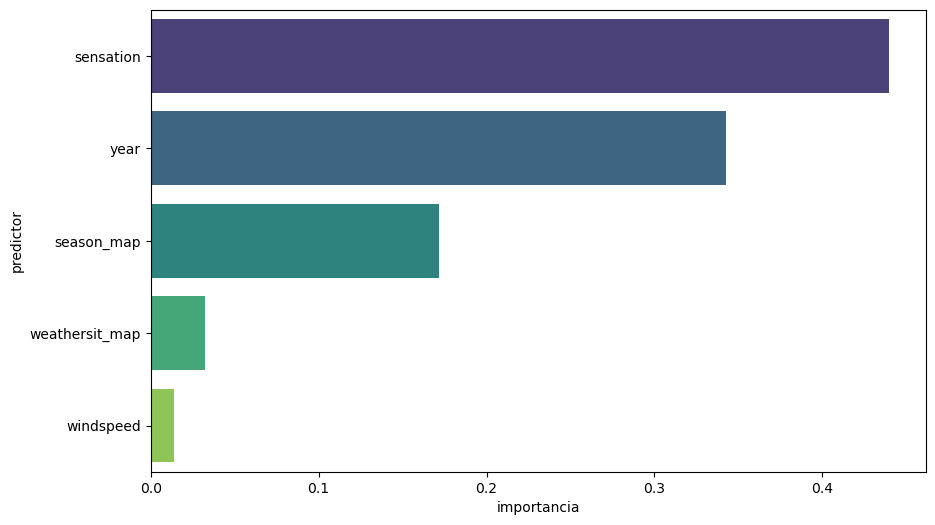

In [4301]:
# por √∫ltimo ploteamos los resultados para verlo de una forma m√°s amigable. 

plt.figure(figsize=(10,6))
sns.barplot(x = "importancia", y = "predictor", data = importancia_predictores, palette="viridis");
plt.show()